Notebook version 1.0, 31 Aug 2021. Written by Joona Andersson / CSC - IT Center for Science Ltd. joona.andersson77@gmail.com

Licensed under the MIT license: http://www.opensource.org/licenses/mit-license.php

Tested on Kvasi, running QLM version 1.2.1: https://research.csc.fi/-/kvasi
***
# Shor's algorithm
Shor's alogrithm was developed by American mathematician Peter Shor in 1994. On a quantum computer it  used to find the prime factors of a given integer $N$ in polynomial time, as opposed to the fastest classical algorithm, which runs in exponential time. More specifically, Shor's algorithm solves the problem of **period finding**, which allows for efficient factoring. This will be demonstrated in this notebook for $N=15$ assuming we are using an ideal quantum computer.<br>
### Period Finding
Let's look at the periodic function: $f(x)=a^x \;\mathrm{mod}\;N$ where $a$ is less than $N$, and they have no common factors. Then, the period $(r)$ is the smallest non-zero integer such that $a^r \;\mathrm{mod}\; N=1$. In the plot below, we see that in the case $N=15$ the period $r$ is 4.<br>
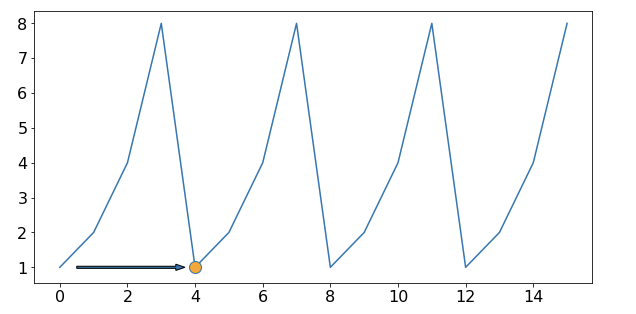
<br>
<p> Since $a^r \;\mathrm{mod}\; N=1$ then:<br>$(a^r-1) \;\mathrm{mod}\; N=0$<br> which means N must divide $a^r-1$, and if $r$ is an even number, then we can write:<br>$a^r-1 = (a^{r/2}-1)(a^{r/2}+1)$<br>Now there is a high probability that either $a^{r/2}-1$ or $a^{r/2}+1$ is a proper factor of $N$ or that they share a greatest common divisor. If $r$ is odd, then we need to choose a different integer $a$, where $ 1<a<N$.<br>


### Quantum sub-routine
The quantum circuits needed for this alogorithm differ for each choice of $N$ and $a$ but this is not a problem since computing the circuit needed for any given pair of integers can be done efficiently. Given $N$, we need to find $Q=2^q$ such that $N^2 ≤ Q ≤2N^2$, which implies $Q/r > N$. The qubit registers need to hold superpositions of values from $ 0 $ to $Q-1$, and need $q$ qubits each $(q = 8)$.
Procedure:
1. Initialize registers to <br>
$\frac{1}{\sqrt{Q}} \sum_{x=0}^{Q-1}\left| x \right> = (\frac{1}{\sqrt{2}}\sum_{x_1=0}^{1}\left| x_1 \right>) \otimes \dots \otimes (\frac{1}{\sqrt{2}}\sum_{x_q=0}^{1}\left| x_q \right>)$
<br> where $\otimes{}$ denotes the tensor product. This is achieved by initializing the qubits to the zero-state and applying the Hadamard gate on the first $q$ qubits. <br>
2. Construct $f(x)$ as a quantum function and apply it to the state above <br>
$U_f\left| x, 0^q \right> = \left| x, f(x) \right>$ <br> <br>
$U_f\frac{1}{\sqrt{Q}} \sum_{x=0}^{Q-1}\left| x, 0^q \right> =  \frac{1}{\sqrt{Q}} \sum_{x=0}^{Q-1}\left| x, f(x) \right>$
<br>
3. Apply the inverse QFT (Quantum Fourier Transform) to the fist $q$ qubits <br>
$U_{QFT}(\left| x \right>) = \frac{1}{\sqrt{Q}} \sum_{y=0}^{Q-1} w^{xy}\left| y \right>$ <br>
4. Measure the first $q$ qubits

In [ ]:
from qat.lang.AQASM import *
from qat.qpus import LinAlg
import numpy as np

In [ ]:
def c_mult_mod15(a, power): # Controlled multiplication by a mod 15
    if a not in [2, 7, 8, 11, 13]:
        raise ValueError("'a' must be 2, 7, 8, 11 or 13")
    rout = QRoutine() # Use QRoutine to create a circuit generator
    wires = rout.new_wires(4)
    for _ in range(power):
        if a in [2, 13]:
            rout.apply(SWAP, wires[0], wires[1])
            rout.apply(SWAP, wires[1], wires[2])
            rout.apply(SWAP, wires[2], wires[3])
        if a in [7, 8]:
            rout.apply(SWAP, wires[2], wires[3])
            rout.apply(SWAP, wires[1], wires[2])
            rout.apply(SWAP, wires[0], wires[1])
        if a == 11:
            rout.apply(SWAP, wires[1], wires[3])
            rout.apply(SWAP, wires[0], wires[2])
        if a in [7, 11, 13]:
            for q in range(4):
                rout.apply(X, wires[q])
    return rout
#Turn the circuit into a custom gate that we can apply later
c_mod15_gate = AbstractGate("Mod15", [int, int], circuit_generator=c_mult_mod15)

### Mod15-circuit visualization
This is the part of the circuit for step 2 of the quantum sub-routine. Change the values of $a$ and **power** to see how the circuit changes based on these parameters.

In [ ]:
a = 7
power = 2
mod_circuit = Program()
qubits = mod_circuit.qalloc(4)
mod_circuit.apply(c_mod15_gate(a, power), qubits)
mod_circuit = mod_circuit.to_circ()

%qatdisplay mod_circuit
%qatdisplay mod_circuit --depth 1

### Inverse QFT
Here we build the Quantum Fourier Transform (dagger) circuit. One can also use the ready-made QFT found in the QLM library.

In [ ]:
def qft_dagger(n):
    circ = QRoutine()
    wires = circ.new_wires(n)
    for i in range(n//2):
        circ.apply(SWAP, wires[i], wires[n-i-1])
    for j in range(n):
        for m in range(j):
            circ.apply(PH(-np.pi/float(2**(j-m))).ctrl(), wires[m], wires[j])
        circ.apply(H, wires[j])
    return circ
qft_dagger_gate = AbstractGate("QFT†", [int], circuit_generator=qft_dagger)

### Visualization of the full circuit

In [ ]:
N = 15
n = N.bit_length()*2
prog = Program()
#A total of twelve qubits are needed for the full circuit
qbits = prog.qalloc(n+4)

#classical bits
cbits = prog.calloc(n)
# Hadamard gates
for q in range(n):
    prog.apply(H, qbits[q])
    
# X-gate for the last qubit
prog.apply(X, qbits[n+3])

# Apply the custom mod15-gate as a controlled gate
for q in range(n):
    prog.apply(c_mod15_gate(a, 2**q).ctrl(), qbits[q] ,qbits[8:])
    
# Inverse QFT
#prog.apply(qft_dagger_gate(n), qbits[:8])

# Alternatively, one can use the QLM library function for this
from qat.lang.AQASM.qftarith import QFT
QFT(8).dag()(qbits[:8])

# Measuremnet
prog.measure(qbits[:8], cbits)

circ = prog.to_circ()

## display circuit
%qatdisplay circ

## see the number of specific gates in the circuit with statistics
from qat.core.util import statistics
print(statistics(circ))

In [ ]:
## run the circuit
job = circ.to_job(nbshots=0)
qpu = LinAlg()
result = qpu.submit(job)

In [ ]:
import matplotlib.pyplot as plt
# resulting states
states = [str(sample.state) for sample in result]
probabilities = [sample.probability for sample in result]

plt.figure(figsize=(10,5))
plt.rcParams['font.size'] = 16
plt.bar(states, probabilities, align='center', width=0.5)
plt.title('Measurement outcome probabilities')
plt.ylabel('probability')
plt.xlabel('state')

plt.show()    

### Quantum sub-routine as a function
This function creates the full circuit as described above given some initial guess $a$. It gives an approximation for the period $r$ in the form $ res/Q ≈ 1/r $. where $res$ is one of the measurement results.

In [ ]:
def run_shor(a):
    n = 8
    prog = Program()
    qbits = prog.qalloc(n+4)
    cbits = prog.calloc(n)
    for q in range(n):
        prog.apply(H, qbits[q])
    prog.apply(X, qbits[n+3])
    for q in range(n):
        prog.apply(c_mod15_gate(a, 2**q).ctrl(), qbits[q] ,qbits[8:])
    prog.apply(qft_dagger_gate(n), qbits[:8])
    circ = prog.to_circ()
    qpu = LinAlg()
    job = circ.to_job(qubits=[0,1,2,3,4,5,6,7], nbshots = 1)
    result = qpu.submit(job)
    phase = result[0]._state / (2**(4))
    return phase

### The complete algorithm
The algorithm starts with some $a$ assuming $a$ is not a factor of 15. Then it finds an approximation of the period $r$ and finds guesses for the factors of $N$ as discussed above. The algorithm repeats this process until it finds at least one non-trivial factor of $N$.

In [ ]:
from math import gcd
from fractions import Fraction

factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = run_shor(a)
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)] # find greatest common divisor
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                print(f"*** Non-trivial factors found: {guess} and {int(N/guess)} ***")
                factor_found = True
                break
    else:
        print('No factors found.')